In [11]:
from BufferGeometry import BufferGeometry
from utils.analysis import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from scipy import linalg as la

In [12]:
# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

def get_buffer_states(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)
    
    hidden_states = outputs.hidden_states

    # Extract buffer states
    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])

    return buffer_states


# Initialize result containers
volumes = []
gd = []
cos_sim = []
mean_vector = []

# Read phrases from file
with open("prompts.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]


# Main loop
for p in prompts:
    # Define matrices to store the results
    phrase_volumes = []
    phrase_gd = []
    phrase_cos_sim = []
    phrase_mean_vector = []

    buffer_states = get_buffer_states(p)

    # Initial Grassmann reference buffer (from first step)
    buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis=0, keepdims=True)
    U, S, Vt = la.svd(buffer_scaled_0)
    eigenvalues = S**2
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9) + 1

    U_reduced = U[:, :n_components]
    S_reduced = np.diag(S[:n_components])
    Vt_reduced = Vt[:n_components, :]
    buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

    # Loop over buffer steps
    for i in range(buffer_states.shape[0]):
        bg = BufferGeometry(buffer_states[i, :, :])

        # Volume
        phrase_volumes.append(bg.volume())

        # Cosine similarity with last buffer step
        phrase_cos_sim.append(bg.cosine_similarity(buffer_states[-1, :, :]))

        # Mean vector
        phrase_mean_vector.append(bg.mean_vector())

        # Reduce current buffer
        buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled)
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9) + 1

        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

        # Grassmann distance
        bg_reduced = BufferGeometry(buffer_reduced)
        phrase_gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))

        # Update reference buffer
        buffer_reduced_0 = buffer_reduced

    # Append results for this phrase
    volumes.append(phrase_volumes)
    gd.append(phrase_gd)
    cos_sim.append(phrase_cos_sim)
    mean_vector.append(phrase_mean_vector)

# Convert to NumPy arrays
volumes = np.array(volumes)
gd = np.array(gd)
cos_sim = np.array(cos_sim)
mean_vector = np.array(mean_vector)

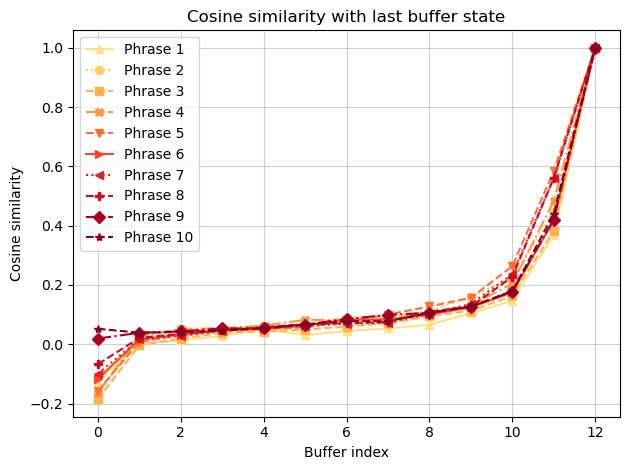

In [13]:
# --- Cosine Similarity Plot ---

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, 10)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]
linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2


plt.figure()
for i in range(cos_sim.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    plt.plot(range(cos_sim.shape[1]), cos_sim[i], color=color, marker=marker, linestyle=linestyle, label=f"Phrase {i+1}")
plt.title("Cosine similarity with last buffer state")
plt.xlabel("Buffer index")
plt.ylabel("Cosine similarity")
plt.grid(alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

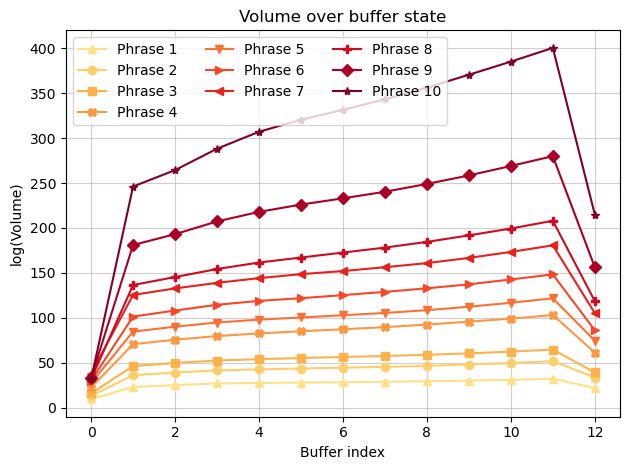

In [14]:
# --- Volume Plot ---
plt.figure()
for i in range(volumes.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    plt.plot(range(volumes.shape[1]), volumes[i], color=color, marker=marker, label=f"Phrase {i+1}")
plt.title("Volume over buffer state")
plt.xlabel("Buffer index")
plt.ylabel("log(Volume)")
#plt.yscale("log")
plt.grid(alpha=0.6)
plt.legend(loc="best", ncols=3)
plt.tight_layout()
plt.show()

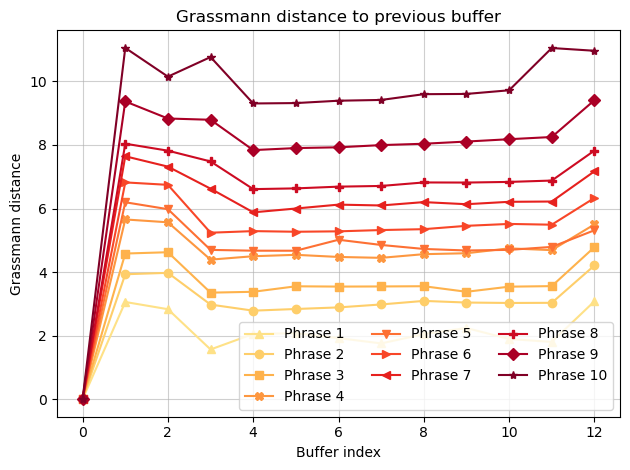

In [15]:
# --- Grassmann Distance Plot ---
plt.figure()
for i in range(gd.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    plt.plot(range(gd.shape[1]), gd[i], color=color, marker=marker, label=f"Phrase {i+1}")
plt.title("Grassmann distance to previous buffer")
plt.xlabel("Buffer index")
plt.ylabel("Grassmann distance")
plt.grid(alpha=0.6)
plt.legend(loc="best", ncols=3)
plt.tight_layout()
plt.show()